# Image segmentation

In [1]:
import numpy as np
import numba as nb
import cv2
import matplotlib.pyplot as plt
from utils import plots
from utils import imgs

In [2]:
I = cv2.imread('images/coins.pgm', 0) / 255.0

### Primal Dual Segmentation

In [14]:
def segmentation_primaldual(I, mu1, mu2, n=100, sigma=0.25, tau=1.0):
    u = np.zeros_like(I)
    # Ill initialization
    u[50:-50, 50:-50] = 1.0
    
    u_tilde = u.copy()
    
    p = np.ones((*I.shape, 2))
    
    
    r = np.zeros((n+1, *I.shape))
    r[0] = u
    
    first_term = (I-mu1)**2 - (I-mu2)**2
    for it in range(1, n+1):
        
        # p ascent
        p_step = p + sigma * np.stack(np.gradient(u_tilde), axis=-1)
        p = p_step / np.maximum(1.0, np.linalg.norm(p_step, axis=2))[:, :, None]
        
        # u descent
        u_new = (u - tau * (first_term - imgs.div(p))).copy()
        
        # Projection to the feasible set
        u_new = u_new / np.maximum(1.0, np.abs(u_new))
        
        #u_new = (u_new + 1.0) / 2.0
        # u_new = (u_new - u_new.min()) / (u_new.max() - u_new.min())
        
        # u tilde
        u_tilde = u_new + (u_new - u)
        u = u_new
        
        r[it] = u
    
    return r

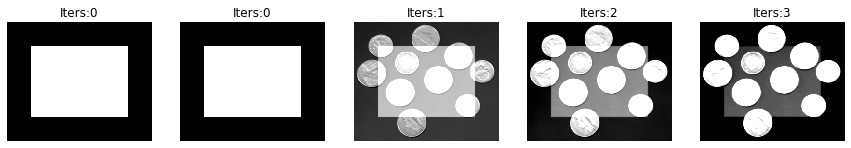

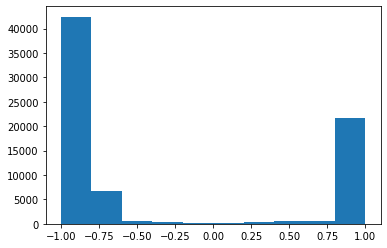

1.0 -1.0


In [16]:
n_iter = 3

res = segmentation_primaldual(I, 1.0, 0.0, n_iter+1)

show = np.linspace(0, n_iter, 5, dtype=int)
plots.grid(res[show], ['Iters:{0}'.format(i) for i in show], 1, 5)

plt.hist(res[-1].flatten())
plt.show()

print(res[-1].max(), res[-1].min())

### Gradient Descent Segmentation

In [7]:
def segmentation_gradient(I, mu1, mu2, n=100, tau=1.0):
    u = np.zeros_like(I)
    # Ill initialization
    u[50:-50, 50:-50] = 1.0
    
    r = np.zeros((n+1, *I.shape))
    r[0] = u
    
    const_term = (I-mu1)**2 - (I-mu2)**2
    for it in range(1, n+1):
        
        grad = np.stack(np.gradient(u), axis=-1)
        u = (u - tau * (const_term - imgs.div(grad / (np.linalg.norm(grad, axis=2)[:, :, None] + 0.001)))).copy()
        
        r[it] = u
    
    return r

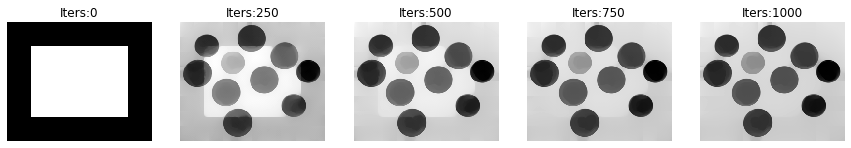

7.060755460030047 -6.298909452366019


In [9]:
n_iter = 1000

res = segmentation_gradient(I, 0.0, 1.0, n_iter+1, tau=0.01)

show = np.linspace(0, n_iter, 5, dtype=int)
plots.grid(res[show], ['Iters:{0}'.format(i) for i in show], 1, 5)
print(res[-1].max(), res[-1].min())

### Gradient Descent Multilabel Segmentation

In [90]:
def segmentation_gradient(I, mus, n=100, tau=1.0):
    u = np.ones((len(mus), *I.shape)) * .33
    
    r = np.zeros((n+1, *u.shape))
    r[0] = u
    
    const_term = [(I-mu)**2 for mu in mus]
    for it in range(1, n+1):
        
        grads = [np.stack(np.gradient(ui), axis=-1) for ui in u] 
        grads_norm_sum = np.sqrt((np.linalg.norm(grads, axis=3)**2).sum(axis=0)[:, :, None] + 0.001)
        for i in range(len(mus)):
            u[i] = u[i] - tau * (const_term[i] - imgs.div(grads[i] / grads_norm_sum))
            
            # Projection to [0, 1]
            u = (u - u.min()) / (u.max() - u.min())
        
        # Projection to u[i].sum() == 1
        u = u / u.sum(axis=0)
            
        
        r[it] = u
    
    return r

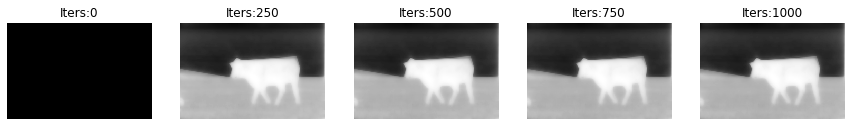

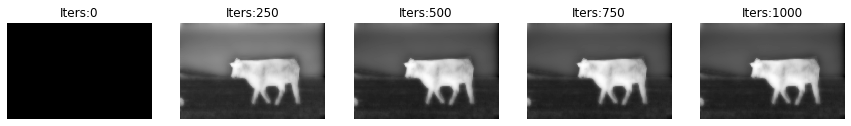

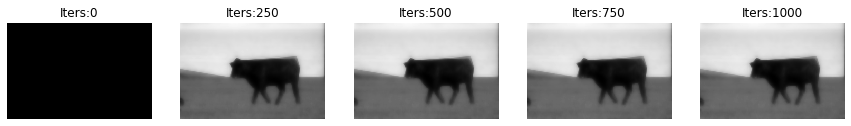

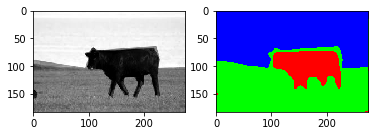

In [97]:
Icow = cv2.imread('images/cow3.jpeg', 0) / 255.0

n_iter = 1000

res = segmentation_gradient(Icow, [0.2, 0.4, 0.95], n_iter+1, tau=0.01)

show = np.linspace(0, n_iter, 5, dtype=int)
plots.grid(res[show, 0], ['Iters:{0}'.format(i) for i in show], 1, 5)
plots.grid(res[show, 1], ['Iters:{0}'.format(i) for i in show], 1, 5)
plots.grid(res[show, 2], ['Iters:{0}'.format(i) for i in show], 1, 5)

segmen = np.zeros((*Icow.shape, 3), np.uint8)
labels = res[-1].argmax(axis=0)
segmen[labels == 0] = [255, 0, 0]
segmen[labels == 1] = [0, 255, 0]
segmen[labels == 2] = [0, 0, 255]

plt.subplot(1, 2, 1)
plt.imshow(Icow, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(segmen)